# Reconocimiento óptico de caracteres


## MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) en un conjunto de datos clásico para el problema de reconocimiento óptico de caracteres. Cuenta con 60000 imágenes de dígitos (0-9) de 28x28 pixeles en escala de gris. De estos 60000 dígitos, 50000 son utilizados para la etapa de entrenamiento y 10000 para validación.

Primeros 10 dígitos de test: [7 2 1 0 4 1 4 9 5 9]


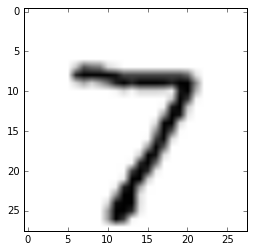

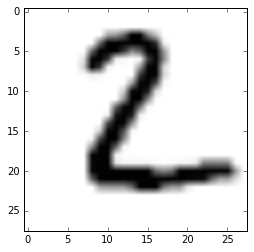

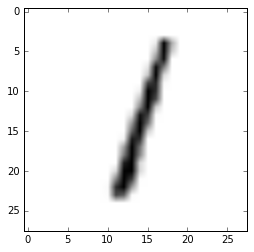

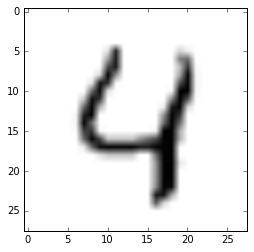

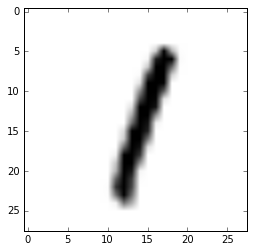

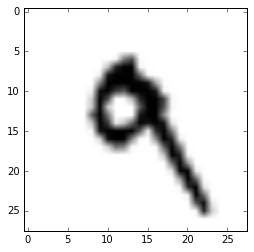

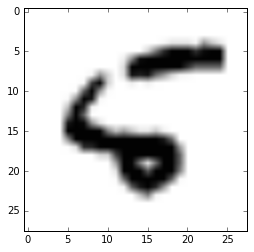

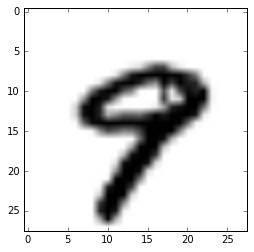

In [9]:
%matplotlib inline
from keras.datasets import mnist
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Primeros 10 dígitos de test: {}'.format(y_test[0:10]))
for i in xrange(0, 10):
    plt.imshow(x_test[i], cmap='Greys')
    plt.show()


Esta es una representación gráfica, sin embargo la computadora ve números crudos...

In [10]:
indice = 0
print('Representación del {}'.format(y_test[indice]))
digito = x_test[indice]
for i in xrange(0, 28):
    linea = ''
    for j in xrange(0, 28):
        linea += '{0:3d} '.format(digito[i][j])
    print(linea)

Representación del 7
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 198 198 198 198

## ¿Qué pasa si intentamos una regresión lineal?

Es decir, que pasa si asumimos que existe una función de los pixels tal que:

$$h(X) = X \cdot w$$

Para facilitar los cálculos, vamos a aplicar algunos preprocesos:
+ Transformar la matriz cada instancia de (28, 28) a un vector de (784) elementos.
    + En realidad, para el conjunto de entrenamiento esto significa transformar (50000, 28, 28) a (50000, 784)
    + Para el entrenamiento (10000, 28, 28) a (10000, 784)
    + Normalizar los valores entre 0 y 1 (cuestiones de precisión).
    + Trabajar todo en arreglos numpy.

In [11]:
import numpy as np
x_train = np.asarray(x_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32)
x_test = np.asarray(x_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.int32)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] ** 2))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] ** 2))
x_train /= 255
x_test /= 255

## ¿Qué resulta de todo esto?

Ahora si, vamos a entrenar y validar el modelo.

Accuracy: 0.098
Aprox Accuracy: 0.2115
0 Error: 28.1852664948
10 Error: 6.06488704681
20 Error: 5.24916791916
30 Error: 4.96609592438
40 Error: 4.8196439743
50 Error: 4.72131919861
60 Error: 4.64705085754
70 Error: 4.58792257309
80 Error: 4.53942728043
90 Error: 4.49878978729
99 Error: 4.46736621857


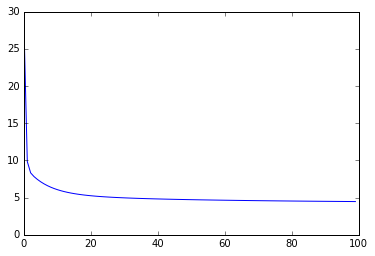

Accuracy: 0.1917
Aprox Accuracy: 0.5392
Predictor: [ 5.  2.  1.  3.  4.  2.  6.  6.  3.  8. -1.  2.  7.  2.  2.  2.  6.  4.
  5.  5.  8.  5.  3.  4.  3.  2.  4.  5.  2.  2.]
Real: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [12]:
import theano
from theano import tensor as T


def lr_accuracy():
    p = predict(x_test)
    p = np.round(p)
    p = p.reshape((p.shape[0]))
    acc = float(np.sum(p == y_test)) / float(y_test.shape[0])
    print('Accuracy: {}'.format(acc))
    pass


def lr_aprox_accuracy():
    p = predict(x_test)
    p = np.round(p)
    p = p.reshape((p.shape[0]))
    acc = float(np.sum((y_test - 1 <= p) * (p <= y_test + 1))) / float(y_test.shape[0])
    print('Aprox Accuracy: {}'.format(acc))
    pass



X = T.matrix()
Y = T.matrix()
w = theano.shared(np.zeros((28 ** 2, 1), dtype=theano.config.floatX))
cost = T.mean(T.sqr(Y - T.dot(X, w)))
gradient = T.grad(cost=cost, wrt=w)
updates = [[w, w - gradient * 0.01]] 
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=T.dot(X, w))
lr_accuracy()
lr_aprox_accuracy()
errors = []
epochs = 100
for i in xrange(0, epochs):
    e = train(x_train, y_train.reshape(y_train.shape[0], 1))
    if i % 10 == 0:
        print('{} Error: {}'.format(i, e))
    errors.append(e)
print('{} Error: {}'.format(i, e))
plt.plot(np.asarray(range(0, epochs)), np.asarray(errors))
plt.show()
lr_accuracy()
lr_aprox_accuracy()
p = predict(x_test)
p = np.round(p)
p = p.reshape((p.shape[0]))
print('Predictor: {}'.format(p[0:30])) 
print('Real: {}'.format(y_test[0:30]))

### Problemas
El problema es que la función de predicción es incapaz de expresar la relación entre los datos y sus etiquetas, por lo que el mínimo de la función de error es muy alto. En este problema se conoce como *bias* del clasificador. <br>
El otro problema es cuando el clasificador llega a un bajo error en el conjunto de entrenamiento, pero el error en el conjunto de prueba es muy alto. Este problema se conoce como *variance*.

## ¿Qué podemos hacer?

Podemos entrenar 10 regresiones lineales, una por cada dígito. La idea es aprender funciones de este estilo<br>

$$h_{d}(x)=\begin{cases}
0 & x\,no\,es\,d\\
1 & x\,es\,d
\end{cases}$$<br>

Es decir, el valor del clasificador $h_{d}(x)$ debería valer $1$ si $x$ representa el dígito $d$, sino $0$.

### Dado un $x$ ¿Cómo se decide que dígito representa?

Simplemente se toma el $d$ que resulta en $h_{d}(x)$ máximo.

Accuracy: 0.098
0 Error: 0.10000000149
10 Error: 0.0569393150508
20 Error: 0.050617210567
30 Error: 0.0480035953224
40 Error: 0.0465380810201
50 Error: 0.0455915592611
60 Error: 0.0449256300926
70 Error: 0.044428344816
80 Error: 0.0440400987864
90 Error: 0.0437263846397


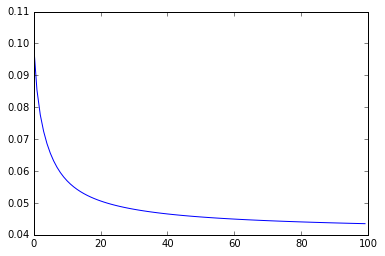

Accuracy: 0.8479
Predicted: [7 2 1 0 4 1 4 9 4 9 0 0 9 0 1 3 9 7 6 4 9 6 6 5 4 0 7 4 0 1]
Real: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [13]:
def to_output(y):
    y_r = np.zeros((y.shape[0], 10))
    for i, v in enumerate(y):
        y_r[i, v] = 1
    return y_r


def multi_accuracy():
    p = predict(x_test)
    p = np.argmax(p, axis=-1)
    acc = float(np.sum(p == y_test)) / float(y_test.shape[0])
    print('Accuracy: {}'.format(acc))

X = T.matrix()
Y = T.matrix()
w = theano.shared(np.zeros((28 ** 2, 10), dtype=theano.config.floatX))
cost = T.mean(T.sqr(Y - T.dot(X, w)))
gradient = T.grad(cost=cost, wrt=w)
updates = [[w, w - gradient * 0.2]]
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=T.dot(X, w))
multi_accuracy()
errors = []
epochs = 100
for i in xrange(0, epochs):
    e = train(x_train, to_output(y_train))
    if i % 10 == 0:
        print('{} Error: {}'.format(i, e))
    errors.append(e)
plt.plot(np.asarray(range(0, epochs)), np.asarray(errors))
plt.show()
multi_accuracy()
p = predict(x_test)
p = np.argmax(p, axis=-1)
print('Predicted: {}'.format(p[0:30]))
print('Real: {}'.format(y_test[0:30]))

## ¿Qué partones son aprendidos para cada regresión lineal?

Patron aprendido para el dígito: 0


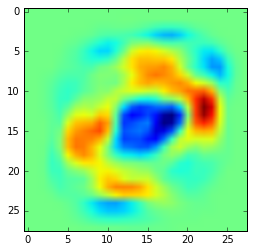

Patron aprendido para el dígito: 1


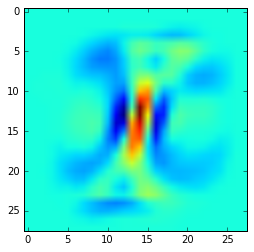

Patron aprendido para el dígito: 2


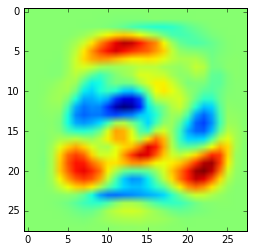

Patron aprendido para el dígito: 3


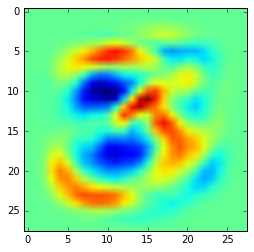

Patron aprendido para el dígito: 4


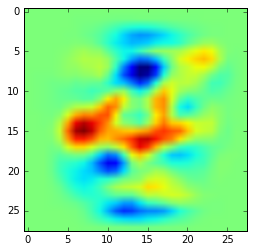

Patron aprendido para el dígito: 5


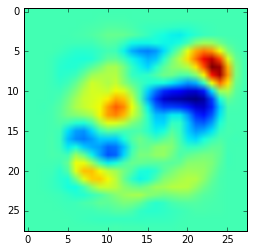

Patron aprendido para el dígito: 6


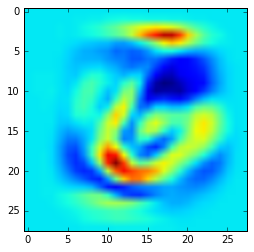

Patron aprendido para el dígito: 7


Patron aprendido para el dígito: 8


Patron aprendido para el dígito: 9


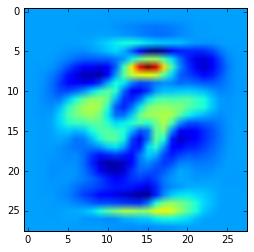

In [14]:
for d in xrange(0, 10):
    print('Patron aprendido para el dígito: {}'.format(d))
    digito = w.get_value()[:, d].reshape((28, 28))
    plt.imshow(digito)
    plt.show()

## Regresión logistica
Como la salida está restringida entre $0$ y $1$, se puede pensar en cambiar la función a una que mapee la función lineal a otra con salida entre esos valores.

$$sigmoid(x)=\frac{1}{1+e^{-x}}$$

![Sigmoid](img/sigmoid.png)

También se puede ajustar la función de error a una más apropiada, conocida como entropía cruzada (*crossentropy*).

$$ce(y,y')=\frac{1}{N}(\sum-(y*log_{2}(y')+(1-y)*log_{2}(1-y'))$$

Accuracy: 0.098
0 Error: 1.0
10 Error: 0.391598880291
20 Error: 0.331495851278
30 Error: 0.29462403059
40 Error: 0.269866406918
50 Error: 0.252025395632
60 Error: 0.238475516438
70 Error: 0.227772399783
80 Error: 0.219060271978
90 Error: 0.211800187826


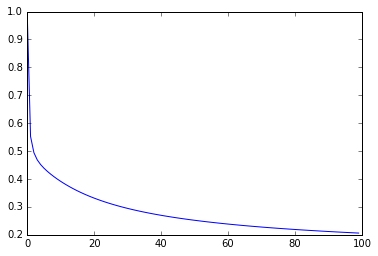

Accuracy: 0.8524
Predicted: [7 2 1 0 4 1 4 9 2 9 0 6 9 0 1 3 9 7 3 4 7 6 6 5 4 0 7 4 0 1]
Real: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [15]:
X = T.matrix()
Y = T.matrix()
w = theano.shared(np.zeros((28 ** 2, 10), dtype=theano.config.floatX))
log_reg = T.nnet.sigmoid(T.dot(X, w))
cost = T.mean(-Y*T.log2(log_reg)-(1-Y)*T.log2(1-log_reg))
gradient = T.grad(cost=cost, wrt=w)
updates = [[w, w - gradient * 0.6]]
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=log_reg)
multi_accuracy()
errors = []
epochs = 100
for i in xrange(0, epochs):
    e = train(x_train, to_output(y_train))
    if i % 10 == 0:
        print('{} Error: {}'.format(i, e))
    errors.append(e)
plt.plot(np.asarray(range(0, epochs)), np.asarray(errors))
plt.show()
multi_accuracy()
p = predict(x_test)
p = np.argmax(p, axis=-1)
print('Predicted: {}'.format(p[0:30]))
print('Real: {}'.format(y_test[0:30]))

## Otra opción

En realidad, como se sabe que el dígito es uno, se puede juntar la salida de cada clasificador para generar un vector de distribución de probabilidades. En general, para esto se utiliza una función conocida como softmax:

$$p(x)_{d}=\frac{e^{h_{d}(x)}}{\sum_{i}e^{h_{i}(x)}}$$

Accuracy: 0.098
0 Error: 0.468995630741
10 Error: 0.321821093559
20 Error: 0.245954483747
30 Error: 0.205877065659
40 Error: 0.181833520532
50 Error: 0.165846526623
60 Error: 0.154415428638
70 Error: 0.145801901817
80 Error: 0.139052167535
90 Error: 0.13360068202


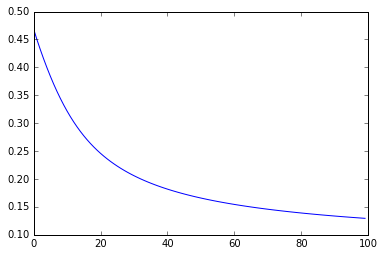

Accuracy: 0.8759
Predicted: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
Real: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [16]:
X = T.matrix()
Y = T.matrix()
w = theano.shared(np.zeros((28 ** 2, 10), dtype=theano.config.floatX))
log_reg = T.nnet.softmax(T.dot(X, w))
cost = T.mean(-Y*T.log2(log_reg)-(1-Y)*T.log2(1-log_reg))
gradient = T.grad(cost=cost, wrt=w)
updates = [[w, w - gradient * 0.7]]
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=log_reg)
multi_accuracy()
errors = []
epochs = 100
for i in xrange(0, epochs):
    e = train(x_train, to_output(y_train))
    if i % 10 == 0:
        print('{} Error: {}'.format(i, e))
    errors.append(e)
plt.plot(np.asarray(range(0, epochs)), np.asarray(errors))
plt.show()
multi_accuracy()
p = predict(x_test)
p = np.argmax(p, axis=-1)
print('Predicted: {}'.format(p[0:30]))
print('Real: {}'.format(y_test[0:30]))